# 전이 학습

In [9]:
import tensorflow as tf
import zipfile

path = "C:/ykio/Study_TF/Ch8_Pre-trained/data/dog"
tf.keras.utils.get_file(path + '/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file(path + '/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file(path + '/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file(path + '/test.zip', 'http://bit.ly/2GHEsnO')

with zipfile.ZipFile(path+"/train.zip","r") as zip_ref:
    zip_ref.extractall(path)

362856448/362841195 [==============================] - 14s 0us/step


In [14]:
import pandas as pd
label_text = pd.read_csv(path + '/labels.csv')
print(label_text.head(),'\n')
label_text.info()
print('\n')
label_text['breed'].nunique()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB




120

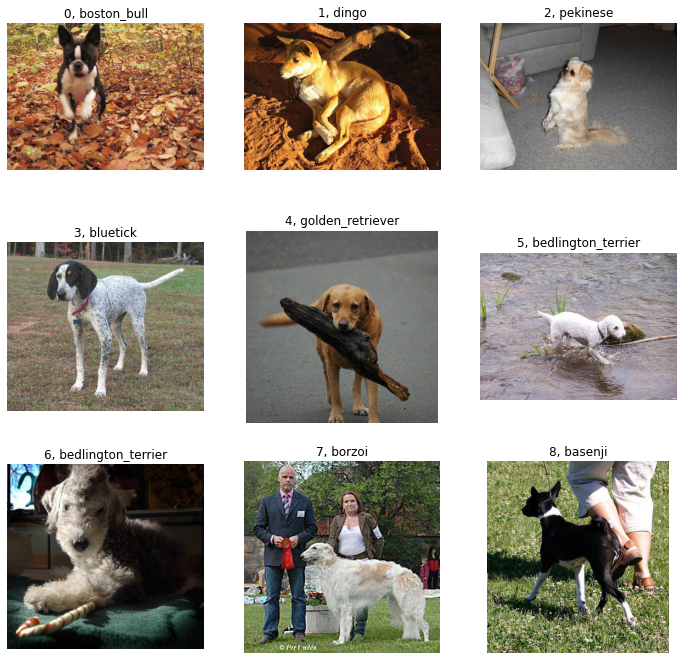

In [15]:
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(path + '/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True
    
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # 라벨이 원-핫 인코딩을 사용하기 때문에 sparse가 아닌 categorical_crossentropy를 사용합니다.
model.summary()

In [21]:
import os
import shutil

os.mkdir(path + '/train_sub')

for i in range(len(label_text)):
    if os.path.exists(path + '/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir(path + '/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy(path + '/train/' + label_text.loc[i]['id'] + '.jpg', path + '/train_sub/' + label_text.loc[i]['breed'])

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory=path + "/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory=path +"/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
241/241 [==============================] - 127s 492ms/step - loss: 3.0941 - accuracy: 0.3259 - val_loss: 1.5182 - val_accuracy: 0.5739
Epoch 2/10
241/241 [==============================] - 93s 384ms/step - loss: 1.5425 - accuracy: 0.6175 - val_loss: 1.1866 - val_accuracy: 0.6514
Epoch 3/10
241/241 [==============================] - 92s 382ms/step - loss: 1.1832 - accuracy: 0.6854 - val_loss: 1.0762 - val_accuracy: 0.6725
Epoch 4/10
241/241 [==============================] - 91s 379ms/step - loss: 1.0203 - accuracy: 0.7273 - val_loss: 1.0182 - val_accuracy: 0.6977
Epoch 5/10
241/241 [==============================] - 91s 379ms/step - loss: 0.8952 - accuracy: 0.7579 - val_loss: 0.9667 - val_accuracy: 0.7081
Epoch 6/10
241/241 [==============================] - 92s 382ms/step - loss: 0.8159 - accuracy: 0.7786 - val_loss: 0.9657 - val_accuracy: 0.7069
Epoch 7/10
241/241 [==============================] - 92s 382ms/step - loss: 0.7379 - accuracy: 0.7991 - val_loss: 0.9484 - val_a

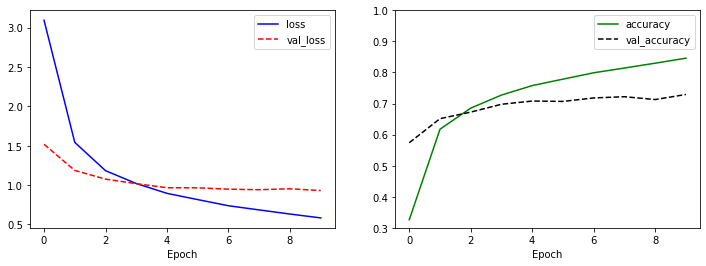

In [22]:
steps_per_epoch = int(7718/32) 
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=10, steps_per_epoch=steps_per_epoch) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

# 특징 추출기

In [24]:
import tensorflow_hub as hub

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
import numpy as np

batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)

train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

0
100
200
300
400
500
600
700
(23058, 2048)
(23058, 120)


In [28]:
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
721/721 [==============================] - 2s 2ms/step - loss: 2.7438 - accuracy: 0.4108 - val_loss: 0.8665 - val_accuracy: 0.7823
Epoch 2/10
721/721 [==============================] - 2s 2ms/step - loss: 1.2111 - accuracy: 0.6879 - val_loss: 0.6669 - val_accuracy: 0.8035
Epoch 3/10
721/721 [==============================] - 2s 2ms/step - loss: 0.9727 - accuracy: 0.7335 - val_loss: 0.6259 - val_accuracy: 0.8123
Epoch 4/10
721/721 [==============================] - 2s 3ms/step - loss: 0.8592 - accuracy: 0.7583 - val_loss: 0.6251 - val_accuracy: 0.8123
Epoch 5/10
721/721 [==============================] - 2s 3ms/step - loss: 0.7680 - accuracy: 0.7788 - val_loss: 0.6243 - val_accuracy: 0.8127
Epoch 6/10
721/721 [==============================] - 2s 3ms/step - loss: 0.7103 - accuracy: 0.7914 - val_loss: 0.6204 - val_accuracy: 0.8119
Epoch 7/10
721/721 [==============================] - 2s 3ms/step - loss: 0.6505 - accuracy: 0.8047 - val_loss: 0.6234 - val_accuracy: 0.8135
Epoch 

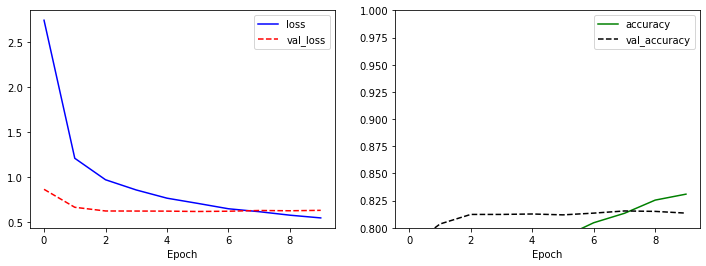

In [30]:
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
plt.legend()

plt.show()

C:/ykio/Study_TF/Ch8_Pre-trained/data/dog/train_sub/brabancon_griffon\25573fa72e5b0052b27d7165a6da47e5.jpg
C:/ykio/Study_TF/Ch8_Pre-trained/data/dog/train_sub/brittany_spaniel\01b849a7e4fbc545f6b2806cb87ab371.jpg
C:/ykio/Study_TF/Ch8_Pre-trained/data/dog/train_sub/appenzeller\18c6389b08ab61f52298bfd1013e81fa.jpg


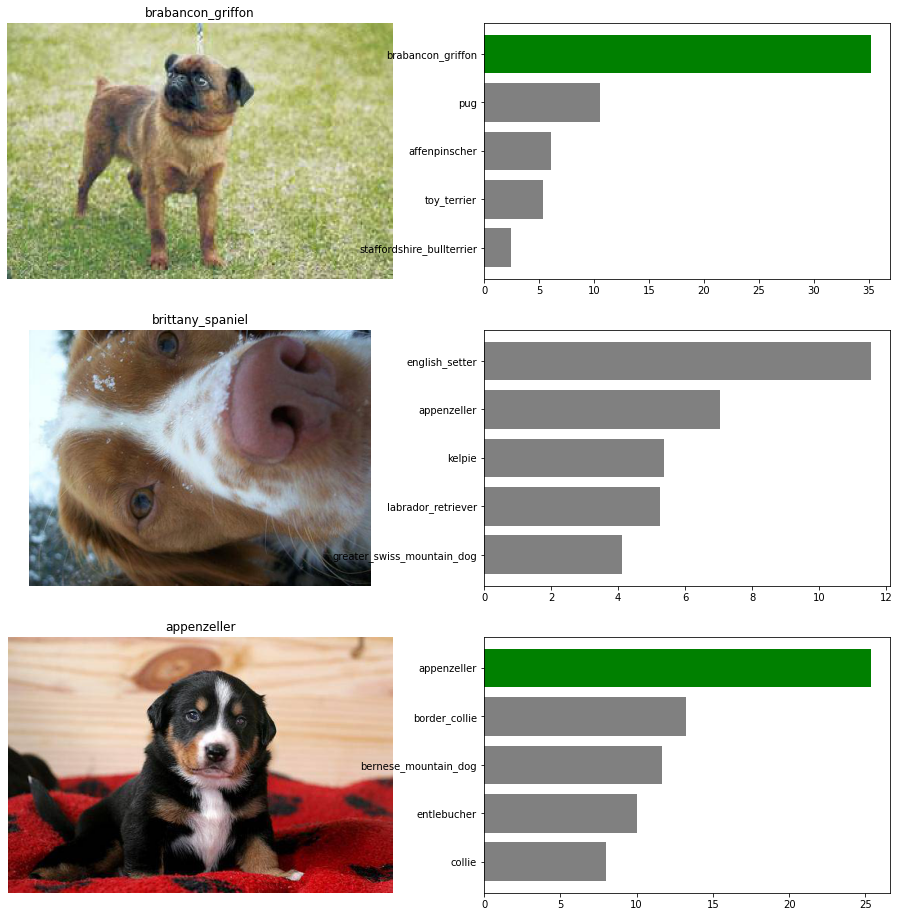

In [42]:
unique_Y = label_text['breed'].unique().tolist()
unique_sorted_Y = sorted(unique_Y)

import cv2
import random
plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    print(image_path)
    real_y = image_path.split('/')[-1].split('\\')[0]
    plt.title(real_y)
    plt.axis('off')
    idx = unique_sorted_Y.index(real_y)
    
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    feature_vector = feature_model.predict(img)
    
    prediction = model.predict(feature_vector)[0]
    
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])